### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd

import scipy.fft
from ipywidgets import interact
import ipywidgets as widgets

import h5py

import torch # downgraded to 1.10
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data
import torch.optim as optim
import torchaudio.transforms as T

import scipy.io

from torch.autograd import Variable

#import tensorflow as tf

import matplotlib.pyplot as plt

### Read data and convert to numpy array

In [4]:
import os

In [30]:
def read_simulated_data(file_name, data_dir):
    name = file_name[:-4]
    print('\nname',name)
    
    file = scipy.io.loadmat(os.path.join(data_dir, file_name))
    # Access specific variables or datasets
    data_variable = file['Ia']  
    print('type(data_variable)', type(data_variable))
    print('data_variable.shape',data_variable.shape)
    data_variable = data_variable[0] 
    print('type(data_variable)', type(data_variable))
    print('data_variable.shape',data_variable.shape)

    time_variable = file['Time']
    print('type(time_variable)', type(time_variable))
    print('time_variable.shape',time_variable.shape)
    time_variable = time_variable[0] # divided by 20 - To Numpy Array
    print('type(time_variable)', type(time_variable))
    print('time_variable.shape',time_variable.shape)
    
    return name, data_variable, time_variable

def read_experimental_data(file_name, data_dir):
    name = file_name[:-4]
    print('\nname',name)
    
    with h5py.File(os.path.join(data_dir, file_name), 'r') as file:
        # Access specific variables or datasets
        data_variable = file['ch_AI_6_3']  
        print('type(data_variable)', type(data_variable))
        print('data_variable.shape',data_variable.shape)
        data_variable = data_variable[0]
        print('type(data_variable)', type(data_variable))
        print('data_variable.shape',data_variable.shape)
        
        time_variable = file['ch_AI_6_3_TIME']
        print('type(time_variable)', type(time_variable))
        print('time_variable.shape',time_variable.shape)
        time_variable = time_variable[0] # divided by 20 - To Numpy Array
        print('type(time_variable)', type(time_variable))
        print('time_variable.shape',time_variable.shape)


    return name, data_variable, time_variable

In [31]:
simulated_files = ['100_3BRB_Simu.mat']
experimental_files = ['100_3BRB.mat']
data_dir = 'data'

data = {}
for file in simulated_files:
    name, data_variable, time_variable = read_simulated_data(file, data_dir)
    data[name] = (data_variable, time_variable)
    
for file in experimental_files:
    name, data_variable, time_variable = read_experimental_data(file, data_dir)
    data[name] = (data_variable, time_variable)


name 100_3BRB_Simu
type(data_variable) <class 'numpy.ndarray'>
data_variable.shape (1, 80001)
type(data_variable) <class 'numpy.ndarray'>
data_variable.shape (80001,)
type(time_variable) <class 'numpy.ndarray'>
time_variable.shape (1, 80001)
type(time_variable) <class 'numpy.ndarray'>
time_variable.shape (80001,)

name 100_3BRB
type(data_variable) <class 'h5py._hl.dataset.Dataset'>
data_variable.shape (1, 1217400)
type(data_variable) <class 'numpy.ndarray'>
data_variable.shape (1217400,)
type(time_variable) <class 'h5py._hl.dataset.Dataset'>
time_variable.shape (1, 1217400)
type(time_variable) <class 'numpy.ndarray'>
time_variable.shape (1217400,)


In [32]:
list(data.keys())

['100_3BRB_Simu', '100_3BRB']

In [36]:
data_variable, time_variable = data['100_3BRB_Simu']

### Obtaining and plotting mel-spectrograms

In [66]:
def get_mel_spectrogram(data, sr=20000, scale=False, two_steps=False):
    if scale:
        data_scaled = (data - data.min()) / (data.max() - data.min()) * 2 - 1
    else:
        data_scaled = data
        
    # Compute the Mel spectrogram 
    if two_steps:
        ft_power_data = np.abs(librosa.stft(data_scaled))**2 
        print('ft_power_data.shape', ft_power_data.shape)
        mel_spec = librosa.feature.melspectrogram(S=ft_power_data, sr=20000, n_mels=80) # n_fft=512*7, hop_length=512,
    else:
        mel_spec = librosa.feature.melspectrogram(y=data_scaled, sr=20000, n_mels=80) # n_fft=512*7, hop_length=512,

    return mel_spec

In [104]:
def plot_mel_spectrogram(S, title='Mel-frequency spectrogram', window=157):
    fig, ax = plt.subplots(figsize=(10,8)) 
    S_cut = S[:,:window]
    S_dB = librosa.power_to_db(S_cut, ref=np.max) 
    img = librosa.display.specshow(S_dB, x_axis='time', 
                             y_axis='mel', sr=20000, 
                             fmax=8000, ax=ax) 
    fig.colorbar(img, ax=ax, format='%+2.0f dB') 
    ax.set_title(title, fontsize=16)
    plt.show()

def plot_signal(y, title, window=1000):
    plt.plot(y[:window])
    plt.title(title)
    plt.show()
    
def compare_signal(y_true, y_rec, title, window=1000):
    plt.plot(y_true[:window], label='True signal')
    plt.plot(y_rec[:window], label='Reconstructed signal')
    plt.title(title)
    plt.legend()
    plt.show()

In [105]:
scale = False
two_steps = False 

exp_sr = 20000
simu_sr = 20000

mel_specs = {}

for key in data.keys():
    print('key', key)
    if 'Simu' in key:
        sr = simu_sr
    else:
        sr = exp_sr
    data_variable = data[key][0]
    mel_spec = get_mel_spectrogram(data_variable, sr=sr, scale=scale, two_steps=two_steps)
    print('mel_spec.shape', mel_spec.shape)
    mel_specs[key] = mel_spec

key 100_3BRB_Simu
mel_spec.shape (80, 157)
key 100_3BRB
mel_spec.shape (80, 2378)


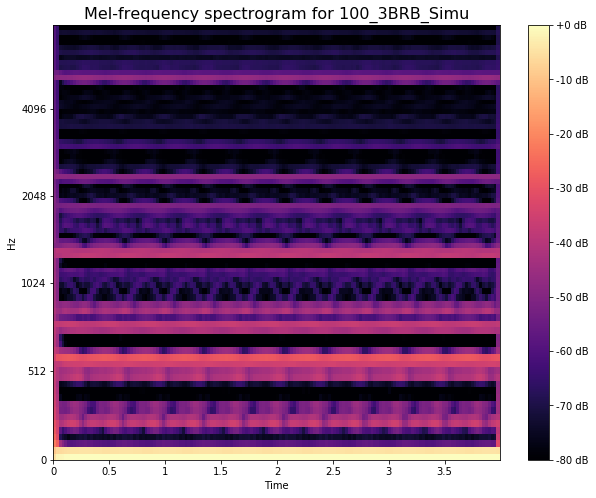

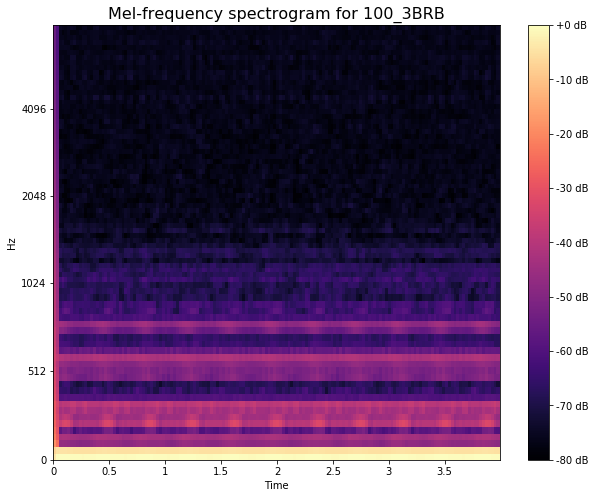

In [106]:
for key in mel_specs.keys():
    plot_mel_spectrogram(mel_specs[key], f'Mel-frequency spectrogram for {key}')

In [107]:
scale = False
two_steps = True # doesn't seem to make a big difference!

exp_sr = 20000
simu_sr = 20000

mel_specs_2steps = {}

for key in data.keys():
    print('key', key)
    if 'Simu' in key:
        sr = simu_sr
    else:
        sr = exp_sr
    data_variable = data[key][0]
    mel_spec = get_mel_spectrogram(data_variable, sr=sr, scale=scale, two_steps=two_steps)
    mel_specs_2steps[key] = mel_spec

key 100_3BRB_Simu
ft_power_data.shape (1025, 157)
key 100_3BRB
ft_power_data.shape (1025, 2378)


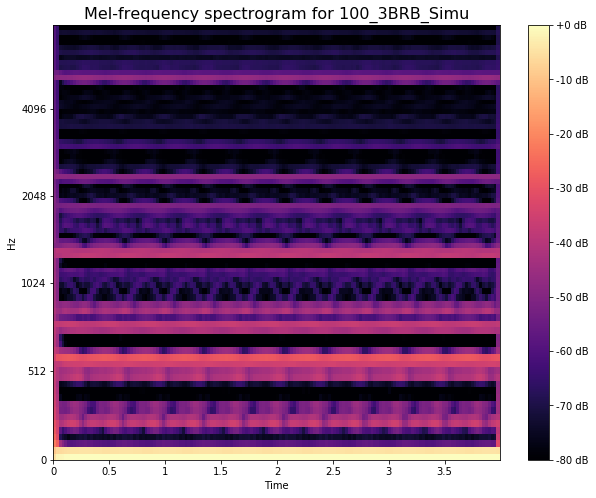

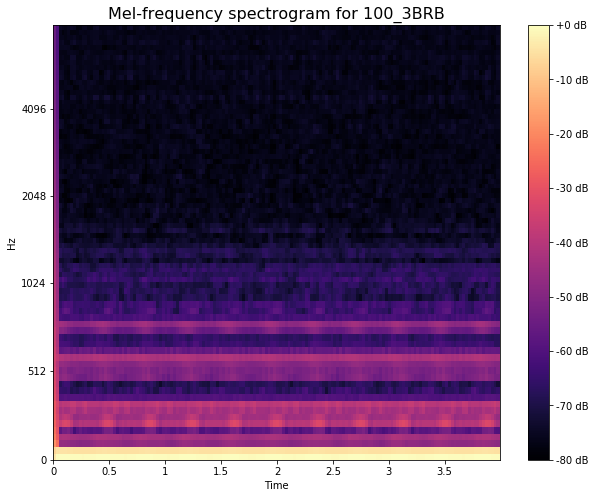

In [108]:
for key in mel_specs_2steps.keys():
    plot_mel_spectrogram(mel_specs_2steps[key], f'Mel-frequency spectrogram for {key}')

### Inverting mel-spectrograms (not needed)

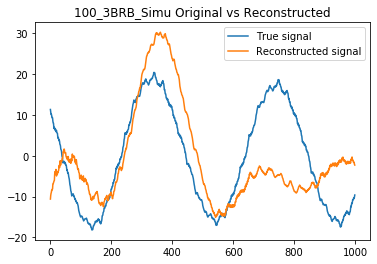

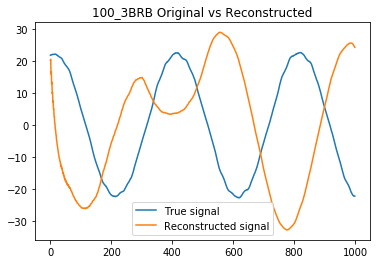

In [85]:
for key in mel_specs_2steps.keys():
    S = librosa.feature.inverse.mel_to_stft(mel_specs_2steps[key]) 
    y_rec = librosa.griffinlim(S)
    compare_signal(data[key][0], y_rec, title=key+' Original vs Reconstructed')

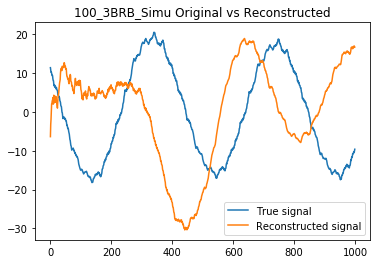

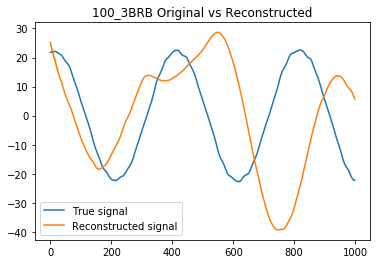

In [86]:
for key in mel_specs.keys():
    S = librosa.feature.inverse.mel_to_stft(mel_specs[key]) 
    y_rec = librosa.griffinlim(S)
    compare_signal(data[key][0], y_rec, title=key+' Original vs Reconstructed')